In [1]:
# https://www.kaggle.com/c/dog-breed-identification

path = '/notebook/kaggle/'
HOME_DIR = path + 'data/dogbreed/'
DATA_DIR = HOME_DIR # + 'sample/'
RESULTS_DIR = DATA_DIR + 'results/'
TRAIN_DIR = DATA_DIR + 'train/'
VAL_DIR = DATA_DIR + 'valid/'
TEST_DIR = DATA_DIR + 'test/'

In [2]:
!echo $CUDA_VISIBLE_DEVICES # Should be 0

0


In [3]:
%matplotlib inline

import os, json, glob, shutil
from skimage.transform import resize
from skimage.io import imsave, imread
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

from keras.models import Sequential, Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, Callback
from keras.regularizers import l2, l1
from keras import backend as K
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.applications import VGG19, ResNet50
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


Set up kaggle config for this competition (after agreeing to rules).

In [4]:
with open(path+'kaggle.txt') as json_file:  
    kg_data = json.load(json_file)
    
username = kg_data['username']
password = kg_data['password']

!kg config -g -u $username -p $password -c 'dog-breed-identification'

#%cd $DATA_HOME_DIR
#!kg download

#!unzip -q sample_submission.csv.zip
#!unzip -q imgs.zip
#!unzip -q driver_imgs_list.csv.zip

### Data set-up

In [49]:
# Show number of files in training/validation directories
train_content = glob.glob(TRAIN_DIR+'/*/*.jpg') # Get list of image files
print('# of training images: '+str(len(train_content)))
val_content = glob.glob(VAL_DIR+'/*/*.jpg')
print('# of validation images: '+str(len(val_content)))
test_content = glob.glob(TEST_DIR+'/unknown/*.jpg')
print('# of test images: '+str(len(test_content)))

test_files = !ls $TEST_DIR"unknown/"

# of training images: 8178
# of validation images: 2044
# of test images: 10357


#### Enforce training/validation split - 
Show number of files in training/validation directories

In [6]:
train_class_folders = ([name for name in os.listdir(TRAIN_DIR)
            if os.path.isdir(os.path.join(TRAIN_DIR, name))]) # Get all directories 
val_class_folders = ([name for name in os.listdir(VAL_DIR)
            if os.path.isdir(os.path.join(VAL_DIR, name))])

train_content_len = []
for folder in train_class_folders:
    contents = os.listdir(os.path.join(TRAIN_DIR,folder)) # Get list of contents
    train_content_len.append(len(contents))
    print(os.path.join(TRAIN_DIR,folder),str(len(contents))+' files')
    
val_content_len = []
for folder in val_class_folders:
    contents = os.listdir(os.path.join(VAL_DIR,folder)) # Get list of contents
    val_content_len.append(len(contents))
    print(os.path.join(VAL_DIR,folder),str(len(contents))+' files')

('/notebook/kaggle/data/dogbreed/train/miniature_schnauzer', '63 files')
('/notebook/kaggle/data/dogbreed/train/sealyham_terrier', '70 files')
('/notebook/kaggle/data/dogbreed/train/french_bulldog', '57 files')
('/notebook/kaggle/data/dogbreed/train/toy_poodle', '64 files')
('/notebook/kaggle/data/dogbreed/train/irish_wolfhound', '90 files')
('/notebook/kaggle/data/dogbreed/train/appenzeller', '68 files')
('/notebook/kaggle/data/dogbreed/train/bedlington_terrier', '71 files')
('/notebook/kaggle/data/dogbreed/train/lakeland_terrier', '81 files')
('/notebook/kaggle/data/dogbreed/train/saint_bernard', '65 files')
('/notebook/kaggle/data/dogbreed/train/labrador_retriever', '73 files')
('/notebook/kaggle/data/dogbreed/train/bouvier_des_flandres', '66 files')
('/notebook/kaggle/data/dogbreed/train/standard_schnauzer', '65 files')
('/notebook/kaggle/data/dogbreed/train/english_setter', '67 files')
('/notebook/kaggle/data/dogbreed/train/german_short-haired_pointer', '64 files')
('/notebook/kag

Split training and validation set such that a percentage of images in the validation set are not in the training set

In [7]:
validation_split = 0.2

# Check difference between number of files in training v. validation set
target_val_size = int((len(train_content)+len(val_content))*validation_split)
split_diff = target_val_size-len(val_content)

# Enforce train/validate split
if (split_diff>0):
    
    print('Moving '+str(split_diff)+' files')
    
    for file_name in train_content[:split_diff]:
        full_file_name = os.path.join(TRAIN_DIR, file_name)

        if (os.path.isfile(full_file_name)):
            #shutil.move(full_file_name, VAL_DIR)
            pass

Move files to appropriate category folder

In [7]:
def arrange_images(image_dir):
    
    for image_name in glob.glob(image_dir+'*.jpg'):

        filename = os.path.basename(image_name)
        breed = (train_data.loc[train_data['id'] == filename[:-4]]['breed']).values[0]
        breed_dir = image_dir+breed
        if (not os.path.isdir(breed_dir)):
            os.mkdir(breed_dir)

        shutil.move(os.path.join(image_dir,image_name), breed_dir)
        #print(os.path.join(image_dir,filename), breed_dir)

#arrange_images(TRAIN_DIR)
#arrange_images(VAL_DIR)

Plot examples of each class of input image (and save figure to .png)

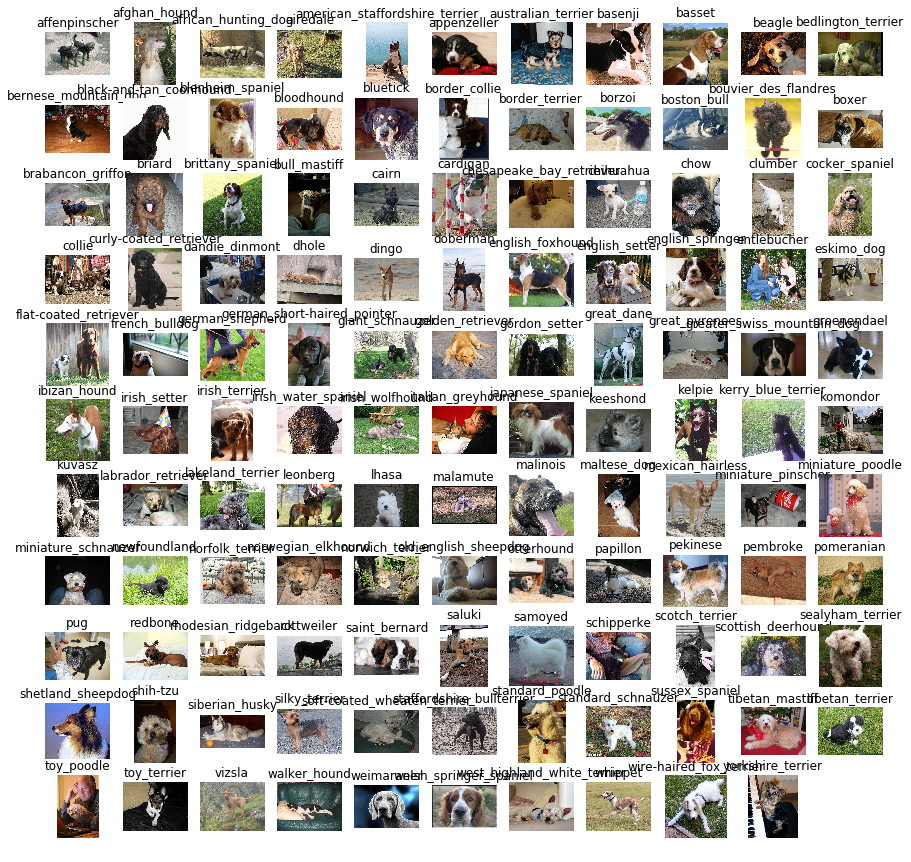

In [9]:
%matplotlib inline
from PIL import Image

fig = plt.figure(figsize=(15, 15)) # , dpi=150

path = TRAIN_DIR

row = col = int(np.ceil(np.sqrt(len(train_class_folders))))

for i,folder in enumerate(sorted(train_class_folders)):
    
    ax = fig.add_subplot(row, col, i+1) # Add sub-axes

    contents = os.listdir(os.path.join(path,folder)) # Get list of contents
    
    # Show image from each class 
    ax.set_title(folder)
    ax.imshow(Image.open(os.path.join(path,folder)+'/'+contents[0]))
    ax.axis('off')
    
fig.savefig(RESULTS_DIR+'training_class_examples.png')


Define model parameters

In [8]:
batch_size = 32
epoch_count = 15
input_shape = (256,256,3)
valid_steps = 75 # Validation steps
output_dim = len(os.listdir(TRAIN_DIR)) # n-way categorical classification task

learning_rate = 1e-4
#decay_rate = learning_rate / epoch_count

fc_layer_size = 512

Load ground truth from .csv file

In [9]:
train_data = pd.read_csv(os.path.join(DATA_DIR,'labels.csv'))
#train_data.loc[train_data['id'] == some_value]

Use ImageDataGenerator to read images from directories

In [15]:
# Rescale images by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.05, rotation_range=15,
                channel_shift_range=10, height_shift_range=0.03, width_shift_range=0.05)  
                #rotation_range=15, height_shift_range=0.05, 
                #shear_range=0.1, channel_shift_range=20, width_shift_range=0.1
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(     
    TRAIN_DIR,  # Target directory   
    shuffle=True,       
    target_size=input_shape[:-1],
    batch_size=batch_size,       
    class_mode='categorical'
    )
valid_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    shuffle=True,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='categorical'
    )

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    
inverted_dict = dict([[v,k] for k,v in valid_generator.class_indices.items()])

Found 8178 images belonging to 120 classes.
Found 2044 images belonging to 120 classes.
('data batch shape:', (32, 256, 256, 3))
('labels batch shape:', (32, 120))


Plot images from generators just to make sure they're okay

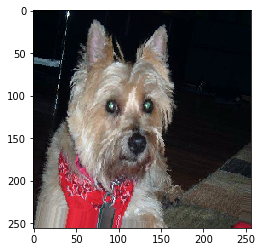

Actual class: cairn


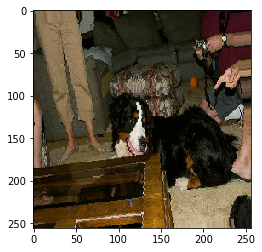

Actual class: bernese_mountain_dog


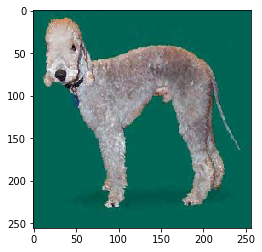

Actual class: bedlington_terrier


'\n# Show a single image augmented several times\nfrom keras.preprocessing import image\nimport matplotlib.pyplot as plt\n\ntrain_first_dir = os.path.join(train_dir, clazzes[0])\nfnames = [os.path.join(train_first_dir, fname) for fname in os.listdir(train_first_dir)]\n\nimg_path = fnames[3]\nimg = image.load_img(img_path, target_size=(img_width, img_height))\nx = image.img_to_array(img)\nx = x.reshape((1,) + x.shape)\n\ni = 0\nfor batch in train_datagen.flow(x, batch_size=1):\n    plt.figure(i)\n    imgplot = plt.imshow(image.array_to_img(batch[0]))\n    i += 1\n    if i % 4 == 0:\n        break\n\nplt.show()\n'

In [13]:
# Test out image generator
inverted_dict = dict([[v,k] for k,v in train_generator.class_indices.items()])

im_vals,class_val = train_generator.next()
#predictions = pt_dr_conv_model.predict(im_vals)

for i in range(0, 3):
    
    # Show image
    plt.imshow(im_vals[i])
    plt.show()

    y_test = np.argmax(class_val, axis=1)
    #y_pred = np.argmax(predictions, axis=1)

    # Show actual category
    category_val = inverted_dict[y_test[i]]
    print('Actual class: '+category_val)

    ## Show predicted category
    #class_preds = inverted_dict[y_pred[i]]
    #print('Predicted class: '+class_preds)
    
    
'''
# Show a single image augmented several times
from keras.preprocessing import image
import matplotlib.pyplot as plt

train_first_dir = os.path.join(train_dir, clazzes[0])
fnames = [os.path.join(train_first_dir, fname) for fname in os.listdir(train_first_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(img_width, img_height))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()
'''

In [11]:
def plot_save_history(history, lr_history, savename):

    fig = plt.figure()
    
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))
    
    ax = fig.add_subplot(3, 1, 1) # Add sub-axes
    ax.plot(epochs, acc, 'b')
    ax.plot(epochs, val_acc, 'bo')
    ax.set_xticks(epochs)
    ax.set_title('Training and validation accuracy')
    
    ax = fig.add_subplot(3, 1, 2) # Add sub-axes
    ax.plot(epochs, loss, 'b')
    ax.plot(epochs, val_loss, 'bo')
    ax.set_xticks(epochs)
    ax.set_title('Training and validation loss')
    
    ax = fig.add_subplot(3, 1, 3) # Add sub-axes
    ax.plot(epochs, lr_history, 'b')
    ax.set_xticks(epochs)
    ax.set_yticks(np.unique(loss_history.lr)) # .tolist()
    ax.set_title('Learning rate')
    ax.set_xlabel('epoch')
    #ax.ticklabel_format(style='sci', axis='y')
    # ["%.1e" % x for x in np.unique(loss_history.lr).tolist()]
    
    plt.show()
    fig.savefig(savename) # , figsize=(5, 5), dpi=150

In [12]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        
# Create learning rate schedules
def step_decay(epoch):
    initial_lrate = learning_rate
    drop = 0.5
    epochs_drop = math.floor(epoch_count/3.0)
    return(initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    return(initial_lrate * np.exp(-k*epoch))

### Create models

In [48]:
# Or just load models, if they've already been fitted
from keras.models import load_model

# Load a compiled model
xcept_mod = load_model(os.path.join(RESULTS_DIR,'xcept_model.h5'))
incept_mod = load_model(os.path.join(RESULTS_DIR,'incept_model.h5'))
resnet_mod = load_model(os.path.join(RESULTS_DIR,'resnet_model.h5'))
print('models loaded')

/usr/local/lib/python2.7/dist-packages/keras/models.py:288: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


models loaded


In [12]:
# Instantiate the VGG16 convolutional base
vgg_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

vgg_base.trainable = False # Freeze the convolutional base

xception_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

xception_base.trainable = False # Freeze the convolutional base

inc_resnet_base = InceptionResNetV2(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

inc_resnet_base.trainable = False # Freeze the convolutional base

resnet_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

resnet_base.trainable = False # Freeze the convolutional base


'''
# Un-freeze the convolutional base
vgg_base.trainable = True
set_trainable = False
for layer in vgg_base.layers:
    if layer.name == 'block5_conv1': # 'block5_conv1'
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:        
        layer.trainable = False
'''

"\n# Un-freeze the convolutional base\nvgg_base.trainable = True\nset_trainable = False\nfor layer in vgg_base.layers:\n    if layer.name == 'block5_conv1': # 'block5_conv1'\n        set_trainable = True\n    if set_trainable:\n        layer.trainable = True\n    else:        \n        layer.trainable = False\n"

Pre-trained convolutional network with drop-out, partially un-frozen convolutional base
- Submissions are evaluated on [Multi Class Log Loss](https://www.kaggle.com/wiki/MultiClassLogLoss) between the predicted probability and the observed target.

In [87]:
xcept_mod = Sequential()
xcept_mod.add(xception_base)
xcept_mod.add(Flatten())
xcept_mod.add(Dropout(0.5)) # Add drop-out
xcept_mod.add(Dense(fc_layer_size, activation='relu'))
xcept_mod.add(Dense(output_dim,
                           activation='softmax')) # 'sigmoid' , kernel_regularizer=l2(0.01)
xcept_mod.compile(optimizer=Adam(), #lr=1e-4, decay=1e-5/10, RMSprop(lr=1e-3), lr=learning_rate, decay=decay_rate
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

xcept_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              134218752 
_________________________________________________________________
dense_2 (Dense)              (None, 120)               123000    
Total params: 155,203,232
Trainable params: 134,341,752
Non-trainable params: 20,861,480
_________________________________________________________________


In [88]:
incept_mod = Sequential()
incept_mod.add(inc_resnet_base)
incept_mod.add(Flatten())
incept_mod.add(Dropout(0.5)) # Add drop-out
incept_mod.add(Dense(fc_layer_size, activation='relu'))
incept_mod.add(Dense(output_dim,
                           activation='softmax')) # 'sigmoid' , kernel_regularizer=l2(0.01)
incept_mod.compile(optimizer=Adam(), #lr=1e-4, decay=1e-5/10, RMSprop(lr=1e-3), lr=learning_rate, decay=decay_rate
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

incept_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 55296)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 55296)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              56624128  
_________________________________________________________________
dense_4 (Dense)              (None, 120)               123000    
Total params: 111,083,864
Trainable params: 56,747,128
Non-trainable params: 54,336,736
_________________________________________________________________


In [89]:
vgg_mod = Sequential()
vgg_mod.add(vgg_base)
vgg_mod.add(Flatten())
vgg_mod.add(Dropout(0.5)) # Add drop-out
vgg_mod.add(Dense(fc_layer_size, activation='relu'))
vgg_mod.add(Dense(output_dim,
                           activation='softmax')) # 'sigmoid' , kernel_regularizer=l2(0.01)
vgg_mod.compile(optimizer=Adam(), #lr=1e-4, decay=1e-5/10, RMSprop(lr=1e-3), lr=learning_rate, decay=decay_rate
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
vgg_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_6 (Dense)              (None, 120)               123000    
Total params: 53,702,840
Trainable params: 33,678,456
Non-trainable params: 20,024,384
_________________________________________________________________


In [13]:
resnet_mod = Sequential()
resnet_mod.add(resnet_base)
resnet_mod.add(Flatten())
resnet_mod.add(Dropout(0.5)) # Add drop-out
resnet_mod.add(Dense(fc_layer_size, activation='relu'))
resnet_mod.add(Dense(output_dim,
                           activation='softmax')) # 'sigmoid' , kernel_regularizer=l2(0.01)
resnet_mod.compile(optimizer=Adam(), #lr=1e-4, decay=1e-5/10, RMSprop(lr=1e-3), lr=learning_rate, decay=decay_rate
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
resnet_mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 120)               123000    
Total params: 25,808,888
Trainable params: 2,221,176
Non-trainable params: 23,587,712
_________________________________________________________________


### Fit model(s)

Epoch 1/10
256/255 [==============================] - 157s 613ms/step - loss: 1.9816 - acc: 0.5567 - val_loss: 1.1073 - val_acc: 0.7334
Epoch 2/10
256/255 [==============================] - 144s 562ms/step - loss: 0.8502 - acc: 0.7746 - val_loss: 1.1388 - val_acc: 0.7216
Epoch 3/10
256/255 [==============================] - 150s 584ms/step - loss: 0.4091 - acc: 0.8819 - val_loss: 0.9283 - val_acc: 0.7554
Epoch 4/10
256/255 [==============================] - 152s 593ms/step - loss: 0.3024 - acc: 0.9102 - val_loss: 0.9617 - val_acc: 0.7490
Epoch 5/10
256/255 [==============================] - 153s 597ms/step - loss: 0.2371 - acc: 0.9287 - val_loss: 0.9866 - val_acc: 0.7593
Epoch 6/10
256/255 [==============================] - 154s 601ms/step - loss: 0.1616 - acc: 0.9539 - val_loss: 0.9020 - val_acc: 0.7759
Epoch 7/10
256/255 [==============================] - 155s 606ms/step - loss: 0.1398 - acc: 0.9592 - val_loss: 0.9298 - val_acc: 0.7632
Epoch 8/10
256/255 [============================

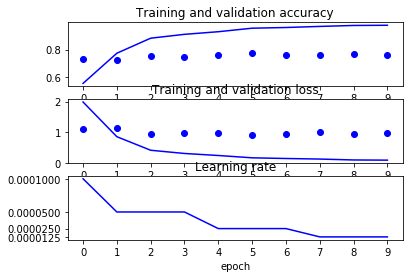

In [91]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

xcept_mod_hist = xcept_mod.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps, callbacks=[loss_history, lrate]
                   )

# Save model weights
xcept_mod.save(os.path.join(RESULTS_DIR,'xcept_model.h5'))

# Plot (and save) model performance
plot_save_history(xcept_mod_hist.history, loss_history.lr, os.path.join(RESULTS_DIR,'xcept_model.png'))

# 10x Adam(lr=1e-4) loss: 0.7636 - acc: 0.7673 - val_loss: 3.1548 - val_acc: 0.3462
# 10x Adam(lr=1e-4),l2(0.01) loss: 1.1097 - acc: 0.8721 - val_loss: 3.9895 - val_acc: 0.3512
# 10x Nadam() bad
# 10x Adam(),step_decay loss: 0.5491 - acc: 0.8430 - val_loss: 2.8711 - val_acc: 0.3756
# 10x SGD(lr=1e-4,momentum=0.90) bad
# 10x frozen Xception base Adam() loss: 0.0198 - acc: 0.9956 - val_loss: 0.7560 - val_acc: 0.8386
# 10x un-frozen Xception base Adam()
# 10x frozen inception_resnet Adam()

Epoch 1/10
256/255 [==============================] - 213s 833ms/step - loss: 1.9683 - acc: 0.5632 - val_loss: 0.9016 - val_acc: 0.7622
Epoch 2/10
256/255 [==============================] - 161s 628ms/step - loss: 0.9364 - acc: 0.7534 - val_loss: 0.9452 - val_acc: 0.7657
Epoch 3/10
256/255 [==============================] - 167s 653ms/step - loss: 0.5503 - acc: 0.8455 - val_loss: 0.8693 - val_acc: 0.7891
Epoch 4/10
256/255 [==============================] - 196s 767ms/step - loss: 0.4462 - acc: 0.8685 - val_loss: 0.9502 - val_acc: 0.7764
Epoch 5/10
256/255 [==============================] - 176s 686ms/step - loss: 0.3624 - acc: 0.8894 - val_loss: 0.9437 - val_acc: 0.7798
Epoch 6/10
256/255 [==============================] - 172s 673ms/step - loss: 0.2792 - acc: 0.9143 - val_loss: 0.8556 - val_acc: 0.7994
Epoch 7/10
256/255 [==============================] - 164s 639ms/step - loss: 0.2388 - acc: 0.9260 - val_loss: 0.8711 - val_acc: 0.7940
Epoch 8/10
256/255 [============================

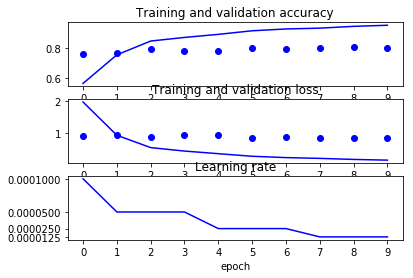

In [92]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

incept_mod_hist = incept_mod.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps, callbacks=[loss_history, lrate]
                   )

# Save model weights
incept_mod.save(os.path.join(RESULTS_DIR,'incept_model.h5'))

# Plot (and save) model performance
plot_save_history(incept_mod_hist.history, loss_history.lr, os.path.join(RESULTS_DIR,'incept_model.png'))

Epoch 1/10
256/255 [==============================] - 160s 625ms/step - loss: 15.9540 - acc: 0.0075 - val_loss: 16.0314 - val_acc: 0.0054
Epoch 2/10
256/255 [==============================] - 144s 561ms/step - loss: 15.9951 - acc: 0.0076 - val_loss: 16.0314 - val_acc: 0.0054
Epoch 3/10
256/255 [==============================] - 141s 551ms/step - loss: 15.9970 - acc: 0.0075 - val_loss: 16.0314 - val_acc: 0.0054
Epoch 4/10
256/255 [==============================] - 142s 553ms/step - loss: 15.9970 - acc: 0.0075 - val_loss: 16.0314 - val_acc: 0.0054
Epoch 5/10
256/255 [==============================] - 141s 550ms/step - loss: 15.9940 - acc: 0.0077 - val_loss: 16.0314 - val_acc: 0.0054
Epoch 6/10
256/255 [==============================] - 144s 562ms/step - loss: 15.9970 - acc: 0.0075 - val_loss: 16.0314 - val_acc: 0.0054
Epoch 7/10
256/255 [==============================] - 145s 566ms/step - loss: 15.9955 - acc: 0.0076 - val_loss: 16.0314 - val_acc: 0.0054
Epoch 8/10
256/255 [==============

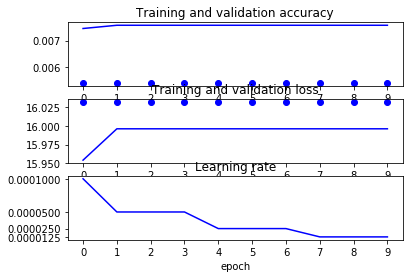

In [93]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

vgg_mod_hist = vgg_mod.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps, callbacks=[loss_history, lrate] # 
                   )

# Save model weights
vgg_mod.save(os.path.join(RESULTS_DIR,'vgg19_model.h5'))

# Plot (and save) model performance
plot_save_history(vgg_mod_hist.history, loss_history.lr, os.path.join(RESULTS_DIR,'vgg19_model.png'))

Epoch 1/15
256/255 [==============================] - 149s 581ms/step - loss: 4.3125 - acc: 0.0946 - val_loss: 5.0909 - val_acc: 0.0122
Epoch 2/15
256/255 [==============================] - 137s 533ms/step - loss: 2.8804 - acc: 0.3187 - val_loss: 5.4046 - val_acc: 0.0201
Epoch 3/15
256/255 [==============================] - 136s 532ms/step - loss: 2.1681 - acc: 0.4380 - val_loss: 4.0492 - val_acc: 0.1688
Epoch 4/15
256/255 [==============================] - 136s 532ms/step - loss: 1.8341 - acc: 0.5102 - val_loss: 1.9243 - val_acc: 0.4667
Epoch 5/15
256/255 [==============================] - 136s 532ms/step - loss: 1.5906 - acc: 0.5654 - val_loss: 1.3730 - val_acc: 0.6057
Epoch 6/15
256/255 [==============================] - 137s 534ms/step - loss: 1.4760 - acc: 0.5839 - val_loss: 1.3339 - val_acc: 0.6081
Epoch 7/15
256/255 [==============================] - 137s 534ms/step - loss: 1.4338 - acc: 0.5961 - val_loss: 1.3192 - val_acc: 0.6115
Epoch 8/15
256/255 [============================

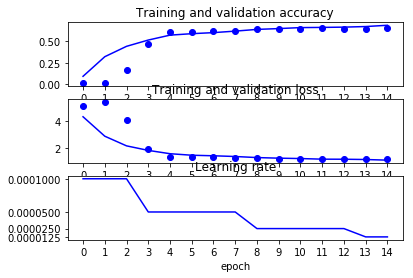

In [14]:
# Create callbacks
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay) # exp_decay

resnet_mod_hist = resnet_mod.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=epoch_count,
    validation_data=valid_generator,
    validation_steps=valid_steps, callbacks=[loss_history, lrate] # 
                   )

# Save model weights
resnet_mod.save(os.path.join(RESULTS_DIR,'resnet_model.h5'))

# Plot (and save) model performance
plot_save_history(resnet_mod_hist.history, loss_history.lr, os.path.join(RESULTS_DIR,'resnet_model.png'))

#### Evaluate model predictions using validation images

In [71]:
for batch_x, batch_y in valid_generator:
    # batch_x contains a batch of images
    # batch_y contains a batch of classes in form of one-hots
    
    xcept_mod_preds = xcept_mod.predict_on_batch(batch_x)
    incept_mod_preds = incept_mod.predict_on_batch(batch_x)
    #vgg_mod_preds = vgg_mod.predict_on_batch(batch_x)
    resnet_mod_preds = resnet_mod.predict_on_batch(batch_x)
    break
    
print(xcept_mod_preds.shape)
print(incept_mod_preds.shape)
#print(vgg_mod_preds.shape)
print(resnet_mod_preds.shape)
print(batch_y.shape)

(32, 120)
(32, 120)
(32, 120)
(32, 120)


In [74]:
from sklearn.metrics import log_loss

print('xcept_model log_loss: ', log_loss(batch_y, xcept_mod_preds))
print('incept_model log_loss: ', log_loss(batch_y, incept_mod_preds))
#print('vgg_model log_loss: ', log_loss(batch_y, vgg_mod_preds))
print('resnet_model log_loss: ', log_loss(batch_y, resnet_mod_preds))

ave_mod_pred = (xcept_mod_preds+incept_mod_preds)/2.0
print('ave. model log_loss: ', log_loss(batch_y, ave_mod_pred))

'''
('xcept_model log_loss: ', 1.5216345840959562)
('incept_model log_loss: ', 0.97057760473131793)
('resnet_model log_loss: ', 1.2368462766171433)
('ave. model log_loss: ', 0.89612466049931072)
'''

('xcept_model log_loss: ', 0.58558130653519713)
('incept_model log_loss: ', 1.0586530031683168)
('resnet_model log_loss: ', 0.94003518755198456)
('ave. model log_loss: ', 0.56127227848891437)


"\n('xcept_model log_loss: ', 1.5216345840959562)\n('incept_model log_loss: ', 0.97057760473131793)\n('resnet_model log_loss: ', 1.2368462766171433)\n('ave. model log_loss: ', 0.89612466049931072)\n"

samoyed


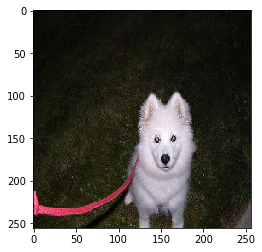

samoyed


In [70]:
i = 7
# Show actual image class
print(inverted_dict[np.argmax(batch_y[i])])

# Show image
plt.imshow(batch_x[i])
plt.show()

# Show predicted image class
print(inverted_dict.values()[np.argmax(xcept_mod_preds[i])])

### Make predictions using human images

In [85]:
human_dir = os.path.join(HOME_DIR,'humans')
human_content = glob.glob(human_dir+'/*.jpg') # Get list of image files

In [86]:
import cv2

x_humans = []
for i,f in enumerate(human_content):
    img = cv2.imread(f)
    x_humans.append(cv2.resize(img[:,:,[2,1,0]], input_shape[:-1]))
img = cv2.imread(os.path.join(TEST_DIR,f))
x_humans  = np.array(x_humans, np.float32) / 255.

#np.save(os.path.join(RESULTS_DIR,'imgs_human.npy'), x_humans)
#print('Saved human image matrix to .npy file')

In [ ]:
i = 56

In [91]:
foo = incept_mod.predict(x_humans)
foo.shape

(200, 120)

In [93]:
np.argmax(incept_mod.predict(x_humans),axis=1)

array([ 20,  55,  64,  20,  64,  20,  64,  64,  64,  64,  64,  64,  64,
        64,  64,  20,  64,  64,  64,  64,  64,  64,  20,  20,  58,  64,
        64,  20,  20,  20,  64,  64,  20,  64,  20,  64,  64,  20,  64,
        64,  64,  55,  20,  64,  88,  20,  20,  64,  64,  64,  64,  64,
        64,  64,  64,  64,   7,  20,  64,  64,  52,  64,   7,  64,   7,
        64,  64,   7,  88,  20,  64,  64,  64,  64,  64,  20,   7,  20,
        64,  74,  64,  64,  64,  20,  64,  20,  74,  20,  15,  64,  20,
        88,  64,  64,   7,  64,  20,  74,  64,  64,   7,  64,  64,  64,
        64,  64,  64,  20,  64,  64,  20,   7,  64,  74,  20,  64,  20,
        55,  64,  64,  20,  64,  20,  75,  64,  20,  20,   7,  64,  64,
        64, 115,  64,  64,  20,  64,  64,  55,  55,  20,  64,  64,  64,
        64,  64,  64,  64,  64,  64,  20,  64,  64,  64,  64,  80,  64,
        64,  20,  64,  88,  64,  64,  64,  20,  64,  64,   7,  64,  64,
        64,  64,  64,  74,  20,  49,  64,  20,  88,  64,  64,  6

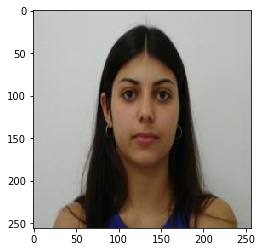

shetland_sheepdog


In [109]:
i += 1

# Show image
plt.imshow(x_humans[i,:,:,:])
plt.show()

# Show predicted image class
human_preds = [inverted_dict[x] for x in np.argmax(xcept_mod.predict(x_humans),axis=1)]
print(human_preds[i])
#print(human_preds)

In [97]:
print(human_preds)

['weimaraner', 'rhodesian_ridgeback', 'yorkshire_terrier', 'yorkshire_terrier', 'shih-tzu', 'yorkshire_terrier', 'yorkshire_terrier', 'yorkshire_terrier', 'doberman', 'miniature_poodle', 'lhasa', 'rhodesian_ridgeback', 'german_short-haired_pointer', 'rhodesian_ridgeback', 'rhodesian_ridgeback', 'groenendael', 'doberman', 'yorkshire_terrier', 'yorkshire_terrier', 'yorkshire_terrier', 'lhasa', 'yorkshire_terrier', 'norfolk_terrier', 'groenendael', 'lhasa', 'lhasa', 'rhodesian_ridgeback', 'silky_terrier', 'yorkshire_terrier', 'groenendael', 'doberman', 'yorkshire_terrier', 'weimaraner', 'lhasa', 'doberman', 'afghan_hound', 'groenendael', 'miniature_poodle', 'yorkshire_terrier', 'scotch_terrier', 'lhasa', 'yorkshire_terrier', 'dandie_dinmont', 'wire-haired_fox_terrier', 'doberman', 'groenendael', 'yorkshire_terrier', 'yorkshire_terrier', 'afghan_hound', 'shetland_sheepdog', 'shetland_sheepdog', 'rhodesian_ridgeback', 'lhasa', 'lhasa', 'yorkshire_terrier', 'brittany_spaniel', 'wire-haired_f

### Make predictions using test images

In [69]:
import cv2

x_test = []
for i,f in enumerate(test_files):
    img = cv2.imread(os.path.join(TEST_DIR,'unknown',f))
    x_test.append(cv2.resize(img, input_shape[:-1]))
img = cv2.imread(os.path.join(TEST_DIR,f))
x_test  = np.array(x_test, np.float32) / 255.

np.save(os.path.join(RESULTS_DIR,'imgs_test.npy'), x_test)
print('Saved test image matrix to .npy file')

Saved test image matrix to .npy file


In [ ]:
x_test = np.load(os.path.join(RESULTS_DIR,'imgs_test.npy'))

In [70]:
xcept_preds = xcept_mod.predict(x_test, verbose=1)
incept_preds = incept_mod.predict(x_test, verbose=1)

ave_preds = (xcept_preds + incept_preds)/2.0

np.save(os.path.join(RESULTS_DIR,'test_preds.npy'), ave_preds)
print('Saved test predictions to .npy file')

10357/10357 [==============================] - 117s 11ms/step
Saved test predictions to .npy file


In [13]:
ave_preds = np.load(os.path.join(RESULTS_DIR,'test_preds.npy'))

In [18]:
'''
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    shuffle=False,
    target_size=input_shape[:-1],
    batch_size=1,
    class_mode='categorical')

xcept_preds = xcept_mod.predict_generator(test_generator,
                                        steps = len(test_content),
                                        verbose = 1)

incept_preds = incept_mod.predict_generator(test_generator,
                                        steps = len(test_content),
                                        verbose = 1)
'''

Found 10357 images belonging to 1 classes.
10357/10357 [==============================] - 1222s 118ms/step


### Create .csv file for submission to Kaggle

For each image in the test set, you must predict a probability for each of the different breeds. The file should contain a header and have the following format:

id,affenpinscher,afghan_hound,..,yorkshire_terrier
000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083
etc.

-----
You must submit a csv file with the image file name, and a probability for each class.
The order of the rows does not matter. The file must have a header and should look like the following:

    img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
    img_0.jpg,1,0,0,0,0,...,0
    img_1.jpg,0.3,0.1,0.6,0,...,0
    ...

In [77]:
# clipped_preds = np.clip(ave_preds,0.05,0.95).tolist()

##test_files = os.listdir(TEST_DIR+'/unknown/')
#test_files = !ls $TEST_DIR"unknown/"

test_content_fnames = [os.path.splitext(x)[0] for x in test_files]
#test_content_fnames = [os.path.splitext(x)[0] for x in os.listdir(TEST_DIR+'/unknown/')]

test_mat = pd.DataFrame(ave_preds, columns=inverted_dict.values())
test_mat.insert(loc=0, column='id', value=test_content_fnames)
test_mat.sort_values(by=['id'])

print(test_mat[:5])
#test_mat = pd.DataFrame([[x]+y for x,y in sorted(zip(test_content_fnames,ave_preds.tolist()))],
#                   columns=['id']+inverted_dict.values())

test_mat.to_csv(os.path.join(RESULTS_DIR,'predictions.csv'), index=False)

                                 id  affenpinscher  afghan_hound  \
0  000621fb3cbb32d8935728e48679680e           0.05          0.05   
1  00102ee9d8eb90812350685311fe5890           0.05          0.05   
2  0012a730dfa437f5f3613fb75efcd4ce           0.05          0.05   
3  001510bc8570bbeee98c8d80c8a95ec1           0.05          0.05   
4  001a5f3114548acdefa3d4da05474c2e           0.05          0.05   

   african_hunting_dog  airedale  american_staffordshire_terrier  appenzeller  \
0                 0.05      0.05                            0.05         0.05   
1                 0.05      0.05                            0.05         0.05   
2                 0.05      0.05                            0.05         0.05   
3                 0.05      0.05                            0.05         0.05   
4                 0.05      0.05                            0.05         0.05   

   australian_terrier  basenji  basset        ...          toy_poodle  \
0                0.05     0.05 

In [78]:
!kg submit $RESULTS_DIR"predictions.csv"
# 1.41932

2.91626
